# Banking Churn Models

## 1. Importing libraries

In [47]:
# basic ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# tools
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, precision_recall_curve

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 2. Loading and preparing the data

In [2]:
df = pd.read_csv('churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Drop useless columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [5]:
# Encoding cateorical columns
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

### Here was Try for some `Feature Engineering` - Didn't improve my metrics across all models

In [6]:
# age bins
#bins = [18, 30, 45, 65, 100]
#labels = ['Young', 'Middle', 'Senior', 'Elderly']
#df['AgeBin'] = pd.cut(df['Age'], bins=bins, labels=labels)

# active membership interactions
#df['InactiveMember'] = 1 - df['IsActiveMember']

# interaction with number of products
#df['HighRiskProducts'] = df['InactiveMember'] * df['NumOfProducts']

# product risk category
#def product_risk(row):
 #   if row['NumOfProducts'] <= 2:
  #      return 'Low'
   # elif row['NumOfProducts'] == 3:
    #    return 'Medium'
   # else:
    #    return 'High'

#df['ProductRisk'] = df.apply(product_risk, axis=1)

# country & gender interactions
#df['Country_Gender'] = df['Geography'] + '_' + df['Gender']

# target encoding for country_gender
#country_gender_churn_rate = df.groupby('Country_Gender')['Exited'].mean()
#df['Country_Gender_Rate'] = df['Country_Gender'].map(country_gender_churn_rate)

#creditScore / balance ratio
#df['BalancePerCredit'] = df['Balance'] / (df['CreditScore'] + 1)  # +1 avoids div by zero

# tenure interactions
#df['Tenure_Products'] = df['Tenure'] * df['NumOfProducts']
#df['Tenure_Active'] = df['Tenure'] * df['IsActiveMember']


# encoding categorical features
#categorical_cols = ['AgeBin', 'ProductRisk']
#df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [7]:
# defining features and target
X = df.drop('Exited', axis=1)
y = df['Exited']

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Here was some try for resampling - Didn't work either. Results became worse on 3-4%. Models didn't really learned to catch churners

In [8]:
#from imblearn.over_sampling import SMOTE

#smote = SMOTE(random_state=42)
#X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
X_train.shape, y_train.shape

((8000, 11), (8000,))

In [10]:
# feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# check class balance
print('Train target distribution:')
print(y_train.value_counts(normalize=True))

Train target distribution:
Exited
0    0.79625
1    0.20375
Name: proportion, dtype: float64


## 3. Logistic Regression Model

In [11]:
# initialize and train
log_reg = LogisticRegression(random_state=42,
                             class_weight='balanced',
                             max_iter=1000)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [12]:
# predictions
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

In [13]:
# evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1593
           1       0.39      0.70      0.50       407

    accuracy                           0.71      2000
   macro avg       0.65      0.71      0.65      2000
weighted avg       0.80      0.71      0.74      2000

ROC-AUC: 0.7771376923919298


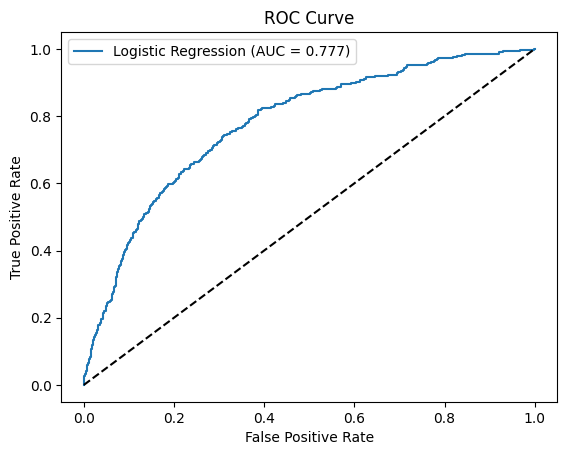

In [14]:
# visualize ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, y_prob):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

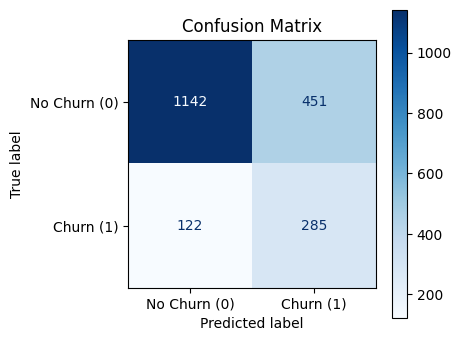

In [15]:
# model predictions
model = log_reg
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn (0)', 'Churn (1)'])

# plot
plt.figure(figsize=(4,4))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.12/dist-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


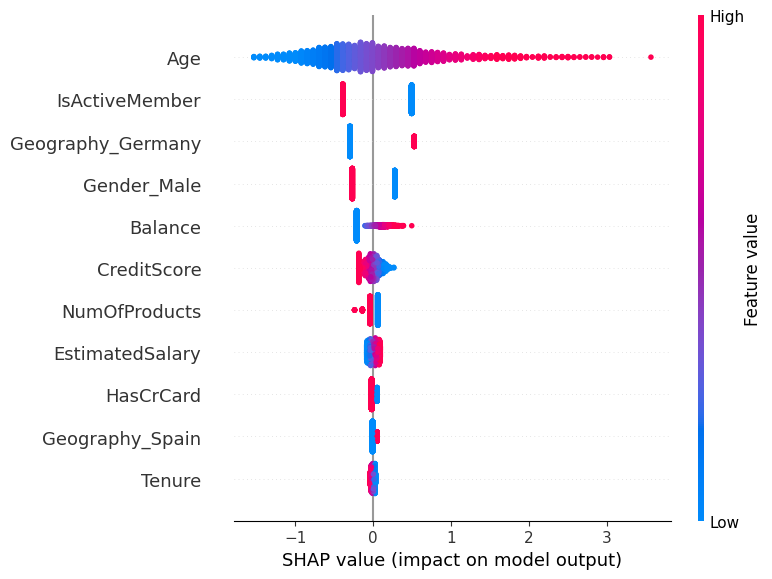

In [16]:
# SHAP explainer
explainer = shap.LinearExplainer(log_reg, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_test)

# convert back to DataFrame for feature names
X_test_df = pd.DataFrame(X_test, columns=df.drop('Exited', axis=1).columns)

# summary plot
shap.summary_plot(shap_values, X_test_df)

## 4. Balanced Random Forest Classifier Model

In [17]:
# balanced random forest
brf = BalancedRandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# fit the model
brf.fit(X_train, y_train)

BalancedRandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [18]:
# predict
y_pred = brf.predict(X_test)
y_proba = brf.predict_proba(X_test)[:, 1]

In [19]:
# evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.87      0.89      1593
           1       0.57      0.70      0.63       407

    accuracy                           0.83      2000
   macro avg       0.74      0.78      0.76      2000
weighted avg       0.85      0.83      0.84      2000

ROC-AUC Score: 0.8597


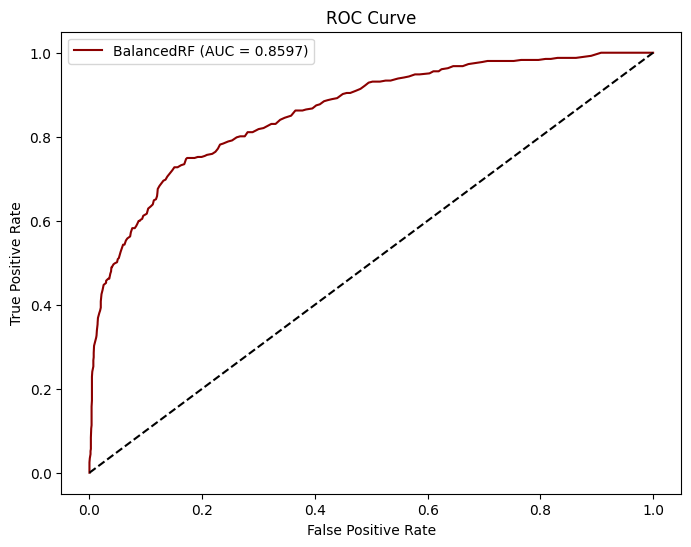

In [20]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'BalancedRF (AUC = {roc_auc:.4f})', color='darkred')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

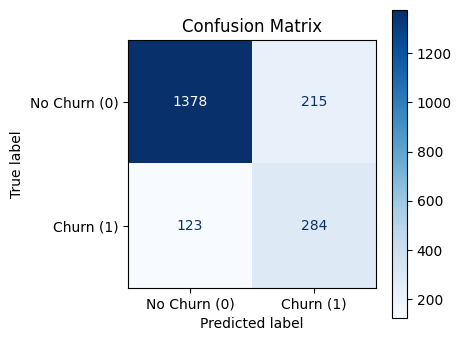

In [21]:
model = brf
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn (0)', 'Churn (1)'])

# plot
plt.figure(figsize=(4,4))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

## 5. XGBoost Model

In [22]:
# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)

# fit
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:29:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)

In [23]:
# predict
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

# evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1593
           1       0.77      0.49      0.60       407

    accuracy                           0.87      2000
   macro avg       0.82      0.73      0.76      2000
weighted avg       0.86      0.87      0.85      2000

ROC-AUC Score: 0.8609


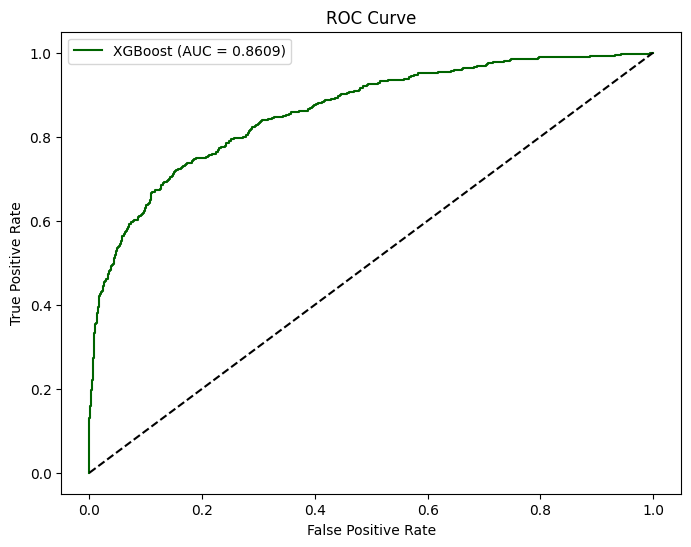

In [24]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.4f})', color='darkgreen')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

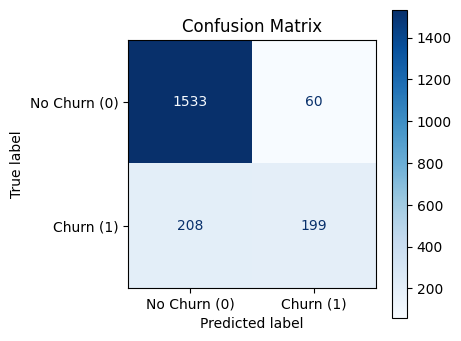

In [25]:
model = xgb_model
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn (0)', 'Churn (1)'])

# plot
plt.figure(figsize=(4,4))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

## 6. LightGBM Model

In [26]:
# LightGBM model
lgbm_model = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# fit
lgbm_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 1630, number of negative: 6370
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 864
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203750 -> initscore=-1.363019
[LightGBM] [Info] Start training from score -1.363019


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=300,
               n_jobs=-1, random_state=42, subsample=0.8)

In [27]:
# predict
y_pred = lgbm_model.predict(X_test)
y_proba = lgbm_model.predict_proba(X_test)[:, 1]

# evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1593
           1       0.73      0.46      0.57       407

    accuracy                           0.86      2000
   macro avg       0.80      0.71      0.74      2000
weighted avg       0.85      0.86      0.84      2000

ROC-AUC Score: 0.8585


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


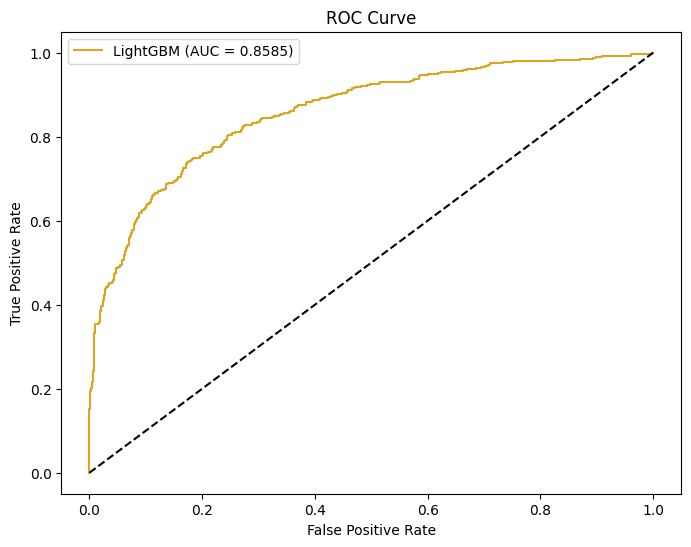

In [28]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'LightGBM (AUC = {roc_auc:.4f})', color='goldenrod')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


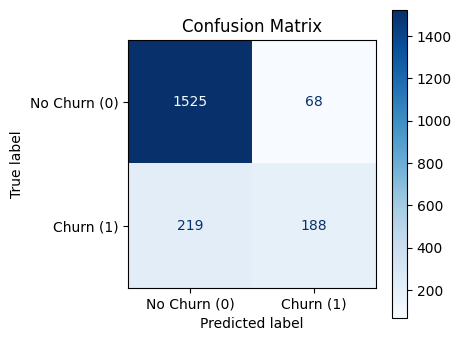

In [29]:
model = lgbm_model
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn (0)', 'Churn (1)'])

# plot
plt.figure(figsize=(4,4))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

* As we can see, Balanced Random Forest did the best. It catches 70% of the churners, and has less than Logistic Regression false alarms. So our customers will be less anoyed with spamming emails or calls from bank that try to convince them to stay.

In [30]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.9 MB/s eta 0:00:00


In [31]:
import optuna

def objective(trial):
    # suggest hyperparameters
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 20),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    }

    model = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_proba = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)

    return roc_auc

In [32]:
# new study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50, timeout=600)

print("Best trial:")
trial = study.best_trial
print(trial.params)
print("Best ROC-AUC:", trial.value)

[I 2025-11-08 03:29:31,895] A new study created in memory with name: no-name-cdda08a6-2af3-43b7-b718-b9ee28c1f8b4
[I 2025-11-08 03:29:41,336] Trial 0 finished with value: 0.8660324423036289 and parameters: {'n_estimators': 455, 'max_depth': 20, 'min_samples_split': 16, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 0.8660324423036289.
[I 2025-11-08 03:29:44,704] Trial 1 finished with value: 0.8417076552669773 and parameters: {'n_estimators': 167, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 0.8660324423036289.
[I 2025-11-08 03:29:51,678] Trial 2 finished with value: 0.8619975908111502 and parameters: {'n_estimators': 390, 'max_depth': 6, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': 'log2'}. Best is trial 0 with value: 0.8660324423036289.
[I 2025-11-08 03:29:57,270] Trial 3 finished with value: 0.8619513195784382 and parameters: {'n_estimators': 359, 'max_depth': 6, 'min_s

Best trial:
{'n_estimators': 174, 'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 2, 'max_features': 'log2'}
Best ROC-AUC: 0.8672971893310877


Chainging Class weight towards churners as our classes are imbalanced. See if that's work and if improves recall and lowers FN

In [33]:
brf_weighted = BalancedRandomForestClassifier(
    n_estimators=491,
    max_depth=9,
    min_samples_split=7,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight={0:1, 1:1.5},  # 1.5 weight for churners
    random_state=42,
    n_jobs=-1
)

# Train
brf_weighted.fit(X_train, y_train)

BalancedRandomForestClassifier(class_weight={0: 1, 1: 1.5}, max_depth=9,
                               min_samples_split=7, n_estimators=491, n_jobs=-1,
                               random_state=42)

In [34]:
# Predict
y_pred = brf_weighted.predict(X_test)
y_proba = brf_weighted.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1593
           1       0.46      0.80      0.58       407

    accuracy                           0.76      2000
   macro avg       0.70      0.78      0.71      2000
weighted avg       0.84      0.76      0.78      2000

ROC-AUC Score: 0.8642


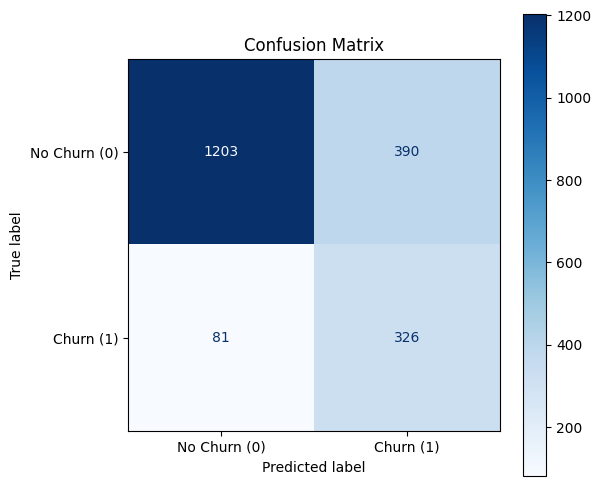

In [35]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn (0)', 'Churn (1)'])
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())
plt.title("Confusion Matrix")
plt.show()

## Combined View

In [37]:
# Store probabilities for each model separately
lr_proba = log_reg.predict_proba(X_test)[:, 1]
brf_proba = brf.predict_proba(X_test)[:, 1]
xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
lgbm_proba = lgbm_model.predict_proba(X_test)[:, 1]
brf_weighted = brf_weighted.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [44]:
# True labels
y_true = y_test

# Probabilities for each model
probas = {
    'LogisticRegression': lr_proba,
    'BalancedRF': brf_proba,
    'XGBoost': xgb_proba,
    'LightGBM': lgbm_proba,
    'Weighted BalancedRF': brf_weighted
}

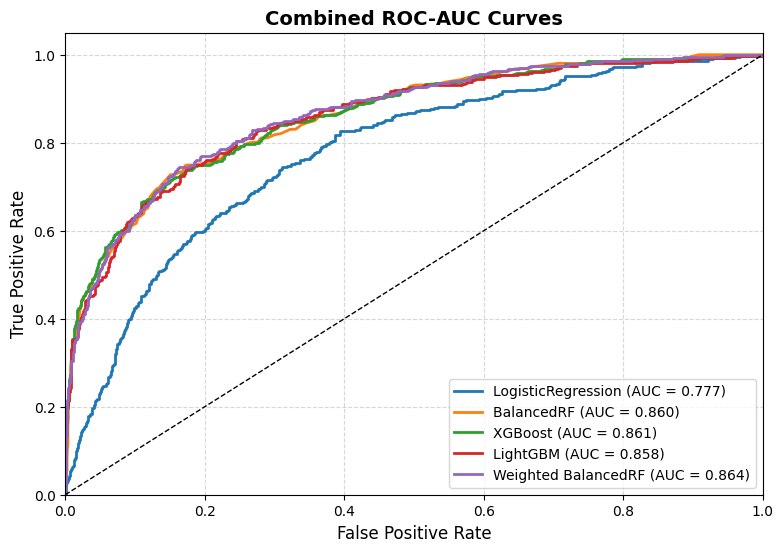

In [45]:
plt.figure(figsize=(9, 6))

for name, y_prob in probas.items():
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Combined ROC-AUC Curves', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

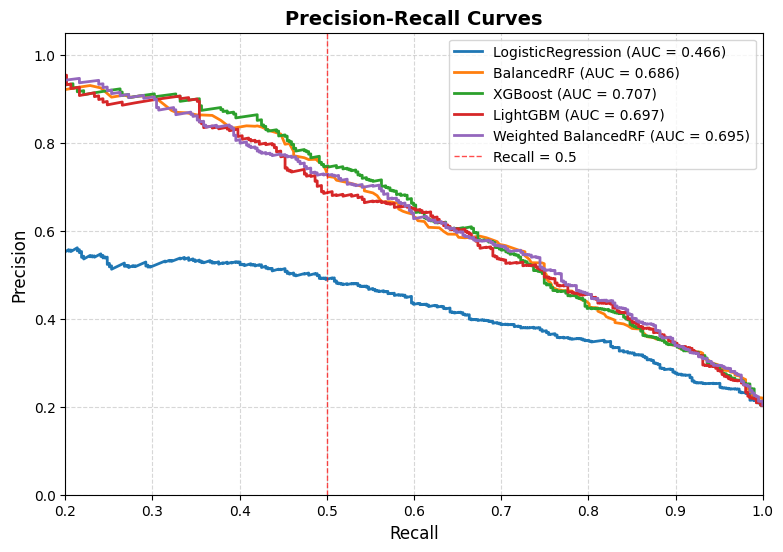

In [53]:
plt.figure(figsize=(9, 6))

for name, y_prob in probas.items():
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})', linewidth=2)

plt.xlim(0.2, 1.0)  # start the x-axis (recall) from 0.2
plt.ylim(0.0, 1.05)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.7, label='Recall = 0.5')


plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()